In [12]:
!pip install tensorflow keras matplotlib seaborn scikit-learn opencv-python

In [13]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [14]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
data_dir = '/content/drive/MyDrive/skin_disease_classifier'

In [17]:
import os

for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    image_count = 0

    for root, _, files in os.walk(class_path):
        image_count += len([f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))])

    print(f"{class_folder}: {image_count} images")

Vitiligo: 2016 images
acne: 1148 images
hyperpigmentation: 22 images
Nail_psoriasis: 2530 images
SJS-TEN: 3184 images


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80/20 split
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [19]:
target_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 7122 images belonging to 5 classes.
Found 1778 images belonging to 5 classes.


In [20]:
print("Class indices:", train_generator.class_indices)

Class indices: {'Nail_psoriasis': 0, 'SJS-TEN': 1, 'Vitiligo': 2, 'acne': 3, 'hyperpigmentation': 4}


In [21]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(train_generator.num_classes, activation='softmax')  # Automatically matches your classes!
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,957 (84.86 MB)

 Trainable params: 22,245,957 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 111s 497ms/step - accuracy: 0.8496 - loss: 0.3943 - val_accuracy: 0.8363 - val_loss: 0.4870
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 112s 504ms/step - accuracy: 0.8385 - loss: 0.4110 - val_accuracy: 0.8543 - val_loss: 0.4735
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 110s 493ms/step - accuracy: 0.8560 - loss: 0.3772 - val_accuracy: 0.8560 - val_loss: 0.4418
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 111s 500ms/step - accuracy: 0.8637 - loss: 0.3617 - val_accuracy: 0.8442 - val_loss: 0.4350
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 112s 503ms/step - accuracy: 0.8750 - loss: 0.3478 - val_accuracy: 0.8690 - val_loss: 0.4341
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 142s 503ms/step - accuracy: 0.8757 - loss: 0.3173 - val_accuracy: 0.8791 - val_loss: 0.3957
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 141s 499ms/step - accuracy: 0.8807 - loss: 0.3360 - val_accuracy: 0.8521 - val_loss: 0.4352
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 111s 496ms/step - accuracy: 0.8878 -

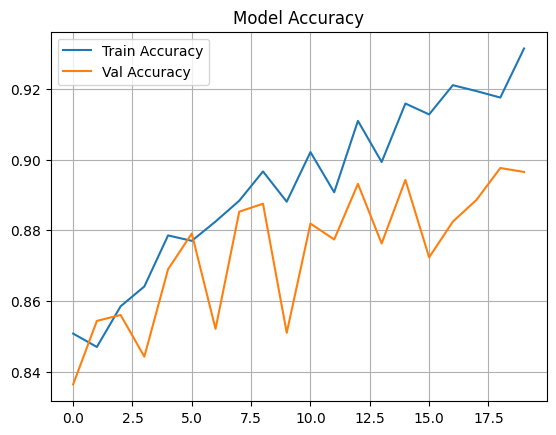

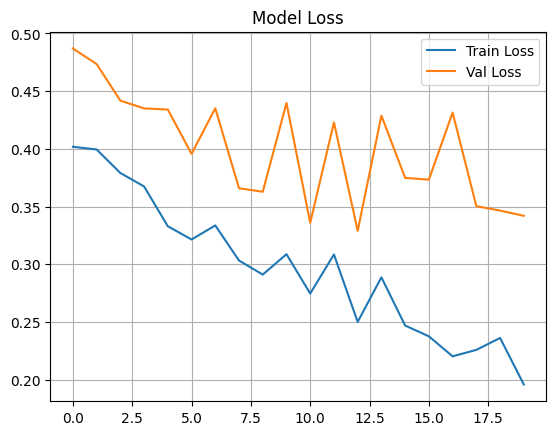

In [24]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
pred_labels = model.predict(val_generator)
pred_classes = np.argmax(pred_labels, axis=1)

# True labels
true_classes = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Classification report
print(classification_report(true_classes, pred_classes, target_names=class_names))

56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step
                   precision    recall  f1-score   support

   Nail_psoriasis       0.26      0.25      0.25       506
          SJS-TEN       0.34      0.37      0.36       636
         Vitiligo       0.22      0.19      0.20       403
             acne       0.14      0.14      0.14       229
hyperpigmentation       0.00      0.00      0.00         4

         accuracy                           0.27      1778
        macro avg       0.19      0.19      0.19      1778
     weighted avg       0.26      0.27      0.26      1778



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


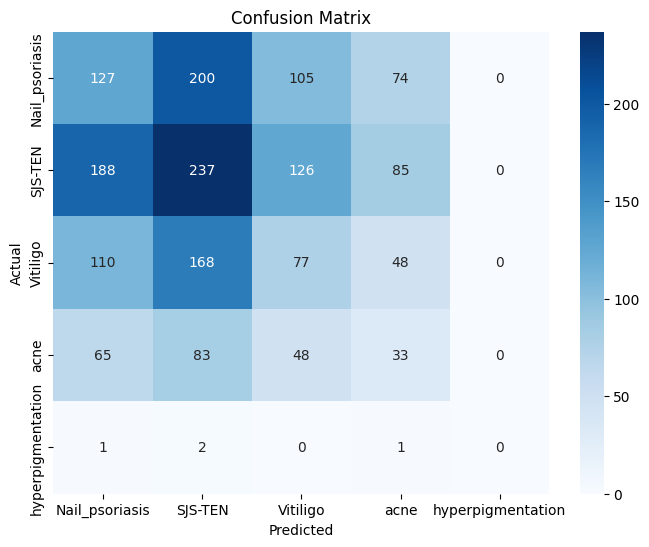

In [26]:
import seaborn as sns
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
model.save('/content/drive/MyDrive/skin_disease_classifier_model.keras')

In [28]:
model.save('your_model.keras', include_optimizer=False)

In [29]:
from tensorflow.keras.models import load_model

model = load_model('your_model.keras')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
from google.colab import files
uploaded = files.upload()

Saving download (1).jpeg to download (1).jpeg


In [ ]:
img = cv2.imread('download (1).jpeg')  # replace with exact name shown after upload

In [31]:
import cv2
import numpy as np

img = cv2.imread('download (1).jpeg')

if img is None:
    print("⚠️ Image could not be loaded. Double-check the path and filename.")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0

    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = class_names[np.argmax(pred)]
    print("✅ Predicted class:", pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
✅ Predicted class: Nail_psoriasis


In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_gradcam(grad_model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap